In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import time
import statistics
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)
size=200
filterSilence=True

"""
TODO:
Could select only real data with events. Done
Import my save.txt routine to optionally write output.
Rename the To TC with rate constants K13 K12 K23 etc.
Would another state help? I don't think so... 4 states should capture realistic bursting.
Could draw the transition matrix as a graph too? Too fancy. User can do this.
Noise could be more authentic still. 
a. Some slow-wave. freq, phase, amp.
b. Some open channel noise. tf.boolean_mask ...if open add white noise? could be slow.
c. replace noise with Sam noise? was it all TF?
d. SPIKE GENERATION SHOULD BE CHANGED, max should be x not abs(x) and number should be abs(x) not be abs(x) +1. X
e. pink noise should also be tf.function decorated!! X

F:: concerned about whether I have consistent use of dt.  In some places it seems with have an array that is T long. In other places this is called 
size and sometimes steps are 1 long and others they are df long @@
OK ...looks like the only time dt is used is when plotting simulated output.
NOTE: Version 107 WSL2 on 355 machine, tried to add a regularised loss to nudge toward means of prior parmeter estimates.

CHANNEL IS LANE 0
RAW IS LANE 1

RUNNING ON WSL2 Office old NUMAN-GPU WSL2 computer with env101. TF version 2.17 I believe.
"""
import os
import logging

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '0' = all logs, '1' = filter out INFO logs, '2' = filter out WARNING logs, '3' = filter out ERROR logs

# Suppress other warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Additional suppression for TensorFlow 2.x
tf.get_logger().setLevel('ERROR')

"""claude suggested this can improve performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')"""

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')

print(f"Number of GPUs detected: {len(gpus)}")


2024-10-08 17:31:01.323079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 17:31:01.900423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 17:31:02.241474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 17:31:03.181468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 17:31:09.783336: W tensorflow/comp

Number of GPUs detected: 1


I0000 00:00:1728405079.008981      59 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728405080.444671      59 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728405080.444808      59 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
n = 1  # Number of channels
dt = tf.constant(0.1, dtype=tf.float32)
T = tf.constant(size, dtype=tf.int32)  # In sample points :-)
#Must be a multiple of 2!!!
#Size of channel (relative to the channels so one channel


I0000 00:00:1728405080.484671      59 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728405080.484803      59 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728405080.484840      59 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728405080.685292      59 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728405080.685367      59 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-08

In [3]:
@tf.function(experimental_compile=True)
def tf_relaxation(binary_sequence, half_life=4.0, relaxation_amount=0.2):
    """
    Apply exponential relaxation to a 1D binary sequence using vectorized TensorFlow operations.
    
    Args:
    binary_sequence: tf.Tensor, shape [time_steps], sequence of 0s and 1s
    half_life: float, the half-life of the exponential decay
    relaxation_amount: float, the amount of relaxation (positive or negative)
    
    Returns:
    tf.Tensor, shape [time_steps]
    """
    # Convert input to float32
    binary_sequence = tf.cast(binary_sequence, tf.float32)
    
    # Calculate decay rate
    decay_rate = tf.math.log(2.0) / half_life
    
    # Find the indices where steps occur
    steps = tf.not_equal(binary_sequence[1:] - binary_sequence[:-1], 0)
    step_indices = tf.where(steps)[:, 0]
    
    # Calculate the time since each step
    time_steps = tf.range(tf.shape(binary_sequence)[0], dtype=tf.float32)
    time_since_step = time_steps[:, tf.newaxis] - tf.cast(step_indices, tf.float32)
    
    # Calculate the exponential decay for each step
    decay = tf.exp(-decay_rate * tf.maximum(time_since_step, 0.0))
    
    # Calculate the relaxation effect
    step_values = tf.gather(binary_sequence, step_indices + 1) - tf.gather(binary_sequence, step_indices)
    relaxation_effect = relaxation_amount * step_values * decay
    
    # Sum the effects of all steps
    total_relaxation = tf.reduce_sum(relaxation_effect, axis=1)
    
    # Add the relaxation to the original sequence
    relaxed_sequence = binary_sequence + total_relaxation
    
    return relaxed_sequence

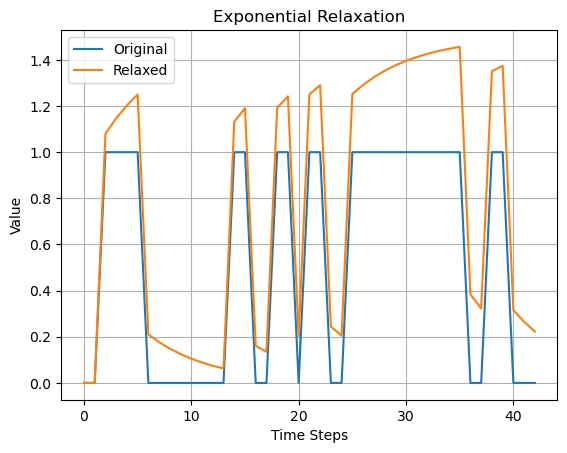

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Create a test sequence
test_sequence = tf.constant([0, 0, 1, 1, 1, 1, 0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0], dtype=tf.float32)

# Apply the relaxation
relaxed_sequence = tf_relaxation(test_sequence, relaxation_amount=-0.5)

# Plot the results
plt.plot(test_sequence.numpy(), label='Original')
plt.plot(relaxed_sequence.numpy(), label='Relaxed')
plt.legend()
plt.title('Exponential Relaxation')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [5]:
"""
And entirely replaced function, by Claude now that doesn't use tf.probability
it seems. Is it really the same?
This needs to be checked. Certainly much faster this way. About 5x faster... it is getting 10% of the GPU cuda use now. was barely visible before.
"""
@tf.function(experimental_compile=True)
def sim_channel(params):
    kc12, kc21, relaxation, Fnoise, scale, offset, relaxT, kco1, koc2, ko12, ko21 = params
    zero = tf.constant(0.0, dtype=tf.float32)

    # Markov chain simulation
    
    row1 = tf.stack([1-kc12, kc12, zero, zero])
    row2 = tf.stack([kc21, 1-kc21-kco1, kco1, zero])
    row3 = tf.stack([zero, koc2, 1-koc2-ko12, ko12])
    row4 = tf.stack([zero, zero, ko21, 1-ko21])
    
    transition_matrix = tf.stack([row1, row2, row3, row4])
    
    # Initial state distribution
    initial_probs = tf.constant([0.3, 0.3, 0.2, 0.2])
    
    # Manual Markov chain simulation
    tf.random.set_seed(int(time.time() * 1000) % (2**31 - 1))
    def body(i, state, channels):
        next_state_probs = tf.gather(transition_matrix, state)
        next_state = tf.random.categorical(tf.math.log([next_state_probs]), num_samples=1)[0, 0]
        channels = channels.write(i, tf.cast(tf.greater_equal(next_state, 2), tf.float32))
        return i+1, next_state, channels

    initial_state = tf.random.categorical(tf.math.log([initial_probs]), num_samples=1)[0, 0]
    channels = tf.TensorArray(tf.float32, size=T)
    _, _, channels = tf.while_loop(
        lambda i, *_: i < T,
        body,
        (0, initial_state, channels)
    )
    
    channels = channels.stack()
    channels = tf.squeeze(channels)

    # Generate pink noise
    white_noise = tf.random.normal(shape=[T])
    fft_len = T // 2 + 1
    f = tf.range(1, fft_len, dtype=tf.float32)
    spectrum = 1.0 / tf.sqrt(f)
    spectrum = tf.concat([tf.constant([1.0]), spectrum], axis=0)
    white_noise_fft = tf.signal.rfft(white_noise)
    pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
    pink_noise = tf.signal.irfft(pink_noise_fft)
    pink_noise -= tf.reduce_mean(pink_noise)
    pink_noise = pink_noise / tf.math.reduce_std(pink_noise)
    noise = pink_noise * Fnoise

    # Add relaxation
    modified_raw_column = (channels * scale) + offset
    modified_raw_column = tf_relaxation(modified_raw_column, half_life=relaxT, relaxation_amount=relaxation)
    
    modified_raw_column += noise

    # Combine channels and modified raw column
    image = tf.stack([channels, modified_raw_column], axis=1)
    
    # Final safeguard against NaN values
    image = tf.where(tf.math.is_nan(image), tf.zeros_like(image), image)
    
    return image

In [6]:
# Parameters for the exponential distribution
num_samples = 5
"""kc12, kc21, relaxation, Fnoise, scale, offset, relaxT, kco1, koc2, ko12, ko21"""
kc12 = tf.constant(0.1, dtype=tf.float32)  # Adjust this value as needed
kc21 = tf.constant(0.1, dtype=tf.float32)  # Adjust this value as needed
kco1 = tf.constant(0.01, dtype=tf.float32)
koc2 = tf.constant(0.01, dtype=tf.float32)
ko12 = tf.constant(0.01, dtype=tf.float32)
ko21 = tf.constant(0.01, dtype=tf.float32)


relaxation = tf.constant(0.5, dtype=tf.float32)
Fnoise = tf.constant(.04, dtype=tf.float32)
SCALE = tf.constant(.6, dtype=tf.float32)
#And an offset
OFFSET = tf.constant(-0.4, dtype=tf.float32)
relaxT=25
# nE = tf.constant(200, dtype=tf.int32) #number of events


# Generate training data
training_data = []
lens=[]
"""Actually replace "Anoise" with relaxation later"""
for sample in tqdm(range(num_samples)):   
    params = tf.stack([kc12, kc21, relaxation, Fnoise, SCALE, OFFSET, relaxT, kco1, koc2, ko12,ko21])  # Use tf.stack instead of tf.constant
    segment = sim_channel(params)
    lens.append(sum(abs(segment)))
    training_data.append(segment)
print(f"Average duration was {sum(lens)/len(lens)}")

100%|█████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.41s/it]

Average duration was [69.6     54.02653]


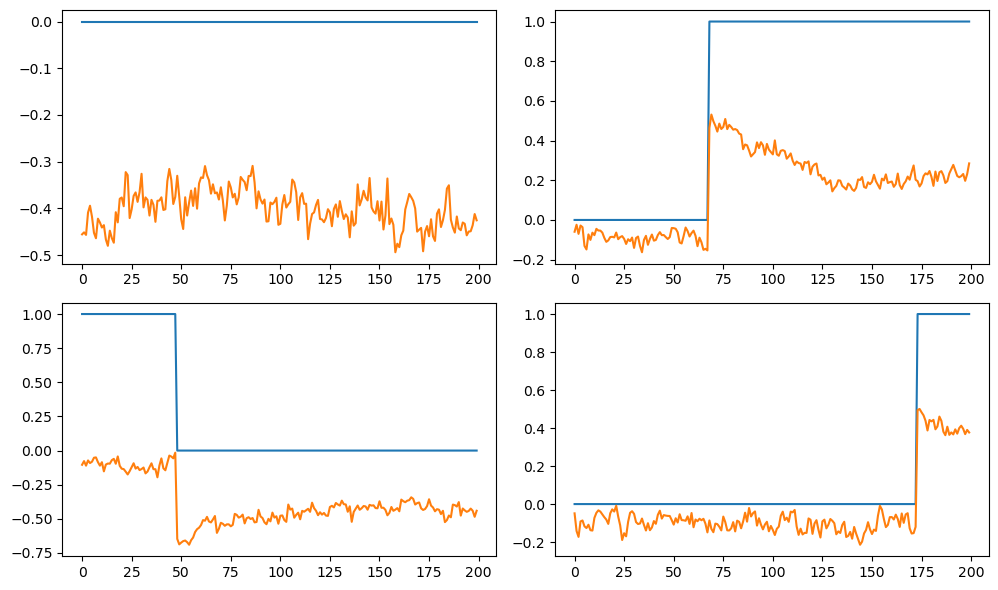

In [7]:
def plotter(data):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
     # Flatten the axs array for easy iteration
    axs = axs.flatten()
    
    for i in range(4):
        axs[i].plot(data[i])
        #axs[i].set_ylim([-200, 200])
    plt.tight_layout()
    plt.show()

plotter(training_data)

In [8]:
#Create REAL Trainging Data
file_path = "Lina2/4096lina11raw.csv"
df = pd.read_csv(file_path, header=None, names=["Raw", "Channels"])
df = df[["Channels","Raw"]]
# now crop to just one phenotype. There seem multiple in this dataset.
df=df[:75000]
#df=df[:12000]
df = pd.concat([df] * 1, ignore_index=True)
noise = np.random.normal(0, 0.01, df["Raw"].shape)
df["Raw"] += noise
num_rows = (len(df) // size) * size
print(num_rows)
df = df.iloc[:num_rows]
data_array = df.to_numpy()
data_tensor = tf.convert_to_tensor(data_array, dtype=tf.float32)
training_data = tf.reshape(data_tensor, [-1, size, 2])
#Calculate real num_samples!
num_samples= tf.shape(training_data)[0]
#num_samples = 10 #debug
#Only use windows where something happened!
filterSilence = True
if filterSilence:
    first_column = training_data[:, :, 0]
    all_same = tf.reduce_all(tf.equal(first_column, first_column[:, 0:1]), axis=1)
    
    # Filter out batches where all values in the first column are the same
    training_data = tf.boolean_mask(training_data, ~all_same)



75000


<Axes: >

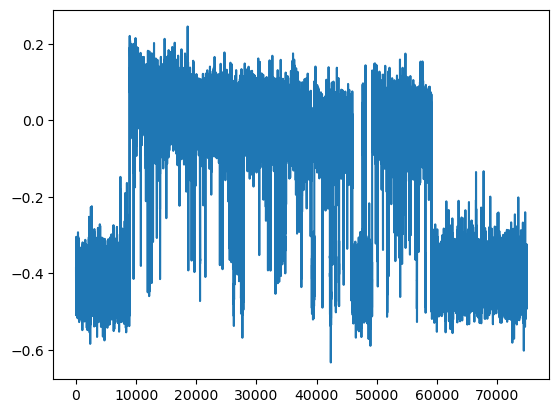

In [9]:
df["Raw"].plot()

In [10]:
# Define the generator model
"""kc12, kc21, relaxation, Fnoise, SCALE, OFFSET, relaxT, kco1, koc2, ko12, ko21"""
gen_input_len=11

def make_generator_model():
    """batch normalisation is terrible!!"""
    noise_input = tf.keras.layers.Input(shape=(gen_input_len,))
    x = tf.keras.layers.Dense(128)(noise_input)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.ReLU()(x)
    
    # Output layer without activation
    raw_output = tf.keras.layers.Dense(gen_input_len)(x)
    
    # Apply appropriate activations/scaling to each output
    kc12 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x) + 1e-6, 1e-6, 1.0))(raw_output[:, 0:1])
    kc21 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x) + 1e-6, 1e-6, 1.0))(raw_output[:, 1:2])
    relaxation = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1.0, 1.0))(raw_output[:, 2:3])
    Fnoise = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x), 0.0, 1.0))(raw_output[:, 3:4])
    scale = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x) + 0.1, 0.1, 10.0))(raw_output[:, 4:5])
    offset = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1.0, 1.0))(raw_output[:, 5:6])
    relaxT = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x) * 100, 1.0, size - 1.0))(raw_output[:, 6:7])
    kco1 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x) + 1e-3, 1e-6, 1.0))(raw_output[:, 7:8])
    koc2 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x) + 1e-6, 1e-6, 1.0))(raw_output[:, 8:9])
    ko12 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x) + 1e-6, 1e-6, 1.0))(raw_output[:, 9:10])
    ko21 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(tf.abs(x) + 1e-6, 1e-6, 1.0))(raw_output[:, 10:11])
    
    output = tf.keras.layers.Concatenate()([kc12, kc21, relaxation, Fnoise, scale, offset, relaxT, kco1, koc2, ko12, ko21])
    
    return tf.keras.Model(inputs=noise_input, outputs=output)

# Define the discriminator model batch, record len, channels = events then noise
num_points = T.numpy().item()
def make_discriminator_model():
    input_shape = (size,2) 
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape input to add channel dimension
    x = tf.keras.layers.Reshape((size, 2))(inputs)
    
    # 1D Convolutional layers
    x = tf.keras.layers.Conv1D(8, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(16, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Dropout(0.3) (x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    """
    # Dense layers
    x = tf.keras.layers.Dense(256, activation='leaky_relu')(x)
    x = tf.keras.layers.Dense(128, activation='leaky_relu')(x)"""
    
    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function(experimental_compile=True)
def regularized_generator_loss(fake_output, generated_params, param_averages, lambda_reg=0.1):
    # Original GAN loss
    gan_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True))
    
    # Regularization term
    reg_loss = tf.reduce_mean(tf.square(generated_params - param_averages))
    
    # Combined loss
    total_loss = gan_loss + lambda_reg * reg_loss
    
    return total_loss #, gan_loss, reg_loss

@tf.function(experimental_compile=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss
    
@tf.function(experimental_compile=True)
def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True))

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)


In [11]:
class ParameterMovingAverage:
    def __init__(self, decay=0.99):
        self.decay = decay
        self.averages = None

    def update(self, new_params):
        if self.averages is None:
            self.averages = new_params
        else:
            self.averages = self.decay * self.averages + (1 - self.decay) * new_params

    def get_averages(self):
        return self.averages

# Initialize the tracker
param_tracker = ParameterMovingAverage()
        

In [12]:
# Training step
@tf.function(experimental_compile=True)
def train_step(real_data):
    param_averages = param_tracker.get_averages()
    # tf.random.set_seed(123)
    noise = tf.random.normal([batch_size, gen_input_len])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_params = generator(noise, training=True)
        # Update the moving averages
        
        try:
            generated_data = tf.map_fn(
                sim_channel, 
                generated_params, 
                fn_output_signature=tf.float32,
                parallel_iterations=1  # This can help with TensorArray issues
            )
            generated_data = tf.ensure_shape(generated_data, [batch_size, size, 2])
        except Exception as e:
            tf.print("sim_channel error:", e)
            return tf.constant(0, dtype=tf.float32), tf.constant(0, dtype=tf.float32)
        
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        # gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gen_loss  = regularized_generator_loss(fake_output, generated_params, param_averages)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    # return gen_loss, disc_loss, gan_loss, reg_loss
    return gen_loss, disc_loss

# Training loop
@tf.function(experimental_compile=True)
def train(dataset, epochs):
    steps_per_epoch = math.floor(num_samples / batch_size)
    #steps_per_epoch =2
    tf.print("steps per epoch", steps_per_epoch)
    for epoch in range(getREALepoch(),epochs,1):
        EgNoise = tf.random.normal([2, gen_input_len])
        #print("EgNoise", EgNoise[0])
        generated_params = generator(EgNoise, training=False)
        param_tracker.update(tf.reduce_mean(generated_params, axis=0))
        print(f"Epoch {epoch + 1}/{epochs}")
        read_set_lr()
        # Initialize loss accumulators for each epoch
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        for step, batch in tqdm(enumerate(dataset.take(steps_per_epoch)), total=steps_per_epoch, ncols=60):
            #clear_output(wait=True)
            if step >= steps_per_epoch:
                break  # Move to the next epoch          
            try:
                gen_loss, disc_loss = train_step(batch)
                #tf.print("gen_loss",gen_loss)
                epoch_gen_loss += gen_loss
                #tf.print("epoch_gen_loss",gen_loss)
                epoch_disc_loss += disc_loss
            except Exception as e:
                print(f"Error during training: {e}")
                break

        #tf.print("epoch_gen_loss",epoch_gen_loss)
        # Calculate average losses for the epoch
        avg_gen_loss = epoch_gen_loss / steps_per_epoch
        avg_disc_loss = epoch_disc_loss / steps_per_epoch
        clear_output(wait=True)
        tf.print(f"Epoch {epoch + 1}/{epochs} - "
              f"Generator Loss: {avg_gen_loss:.8f}, "
              f"Discriminator Loss: {avg_disc_loss:.8f}")
        checkpoint.save(file_prefix = 'markovCheckpoints/checkpoint')
        # Generate and plot sine waves
        egs=2
        
        # Generate and plot data
        EgNoise = tf.random.normal([egs, gen_input_len])
        #print("EgNoise", EgNoise[0])
        generated_params = generator(EgNoise, training=False)
        #print(steps_per_epoch)
        # Define parameter names kc12, kc21, relaxation, Fnoise, scale, offset, relaxT, kco1, koc2, ko12, ko21
        param_names = ['kc12', 'kc21', 'relaxation', 'Fnoise', 'scale',"offset","relaxT", "kco1", "koc2","ko12","ko21"]
        random_index1 = tf.random.uniform(shape=[], minval=0, maxval=egs-1, dtype=tf.int32)

        params_list = generated_params[random_index1].numpy().tolist()
        #Might be fun to collect these up to plot convergence if wanted?
                
        # Print each parameter with its name
        with tf.io.gfile.GFile('output.csv', mode='a') as file:
            # Check if the file is empty to write the header
            if file.tell() == 0:
                file.write(','.join(param_names) + '\n')

            for name, param in zip(param_names, params_list):
                tf.print(f"{name}: {round(param, 2)}|", end = " ")
                file.write(f"{name},{round(param, 2)}\n")
        """ 
        gen_waves=[]
        for i in range(egs):
            gen_waves.append( sim_channel(generated_params[i]) )"""
        
        random_index2 = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(training_data)[0], dtype=tf.int32)
        """
        biPlotter([gen_waves[random_index1],training_data[random_index2]], random_index1, random_index2, epoch)
        """
        gen_wave = sim_channel(param_tracker.get_averages())
        biPlotter([gen_wave,training_data[random_index2]], 0, random_index2, epoch)
        if (epoch + 1) % 10 == 0:
            print(f"Completed {epoch + 1} epochs")
        if writeNow:
            writeMe(epoch=epoch)

In [13]:
def biPlotter(data, n, m, epoch):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    axs[0].plot(data[0] )
    axs[0].set_title(f"Generated Wave, record {n}, epoch {epoch}")
    axs[0].set_ylim([-1,1.2])
    axs[1].plot(data[1] )
    axs[1].set_title(f"Training Data, record {m}")
    axs[1].set_ylim([-1,1.2])
    plt.tight_layout()
    plt.savefig(f"chanFigs/fig{epoch}.png")
    plt.show() 

In [26]:
def getREALepoch() -> int:
    import glob
    import os
    import re
    """
    Save the current image to the working directory of the program.
    """
    currentfiles = glob.glob("markovCheckpoints/*.index")
   
    numList = [0]
    for file in currentfiles:
        i = os.path.splitext(file)[0]
        try:
            pattern = r'-(\d+)'
            num = re.findall(pattern, i)[0]
            numList.append(int(num))
        except IndexError:
            pass
    numList = sorted(numList)
    return numList[-1]

In [27]:
batch_size = 10
"""training_dataset = tf.data.Dataset.from_tensor_slices(
    training_data).shuffle(5000).batch(batch_size, drop_remainder=True).repeat()"""
buffer_size = 5000  # Keeping your current shuffle buffer size

training_dataset = tf.data.Dataset.from_tensor_slices(training_data)
training_dataset = (training_dataset
    .cache()  # Cache the dataset in memory
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)  # Prefetch next batch while current batch is being processed
    .repeat()  # Repeat the dataset indefinitely
)


In [35]:
def writeMe(samples=10000, dt=dt, epoch=0, file="markovData/output.parquet"):
    sampleNoise = tf.random.normal([samples, gen_input_len])
    generated_params = generator(sampleNoise, training=False)
    gen_waves=[]
    for i in tqdm(range(samples)):
        gen_waves.extend( sim_channel(generated_params[i]) )
    df = pd.DataFrame(gen_waves, columns=["Channels", "Noisy Current"])
    df["Time"] = dt * pd.Series(range(len(df)))
    df = df[["Time", "Channels", "Noisy Current"]]
    df["Channels"] = df["Channels"].apply(lambda x: x.numpy().item())
    df["Noisy Current"] = df["Noisy Current"].apply(lambda x: x.numpy().item())
    df.to_parquet(f"{file}")
    print(f"Data saved to {file}")
    

In [17]:
@tf.function(experimental_compile=True)
def read_set_lr():
    with open("lr.txt", "r+") as my_file:
        data = my_file.read()
        split = data.split('\n')
        parse_lr_from_file = lambda string: float(string.split(":")[1])
        new_gen_lr = parse_lr_from_file(split[1])
        new_disc_lr = parse_lr_from_file(split[2])
        generator_optimizer.learning_rate.assign(tf.cast(new_gen_lr, generator_optimizer.learning_rate.dtype))
        discriminator_optimizer.learning_rate.assign(tf.cast(new_disc_lr, discriminator_optimizer.learning_rate.dtype))
        tf.print(f"dLR: {discriminator_optimizer.learning_rate.value.numpy():.3e},\
                    gLR: {generator_optimizer.learning_rate.value.numpy():.3e}")

In [18]:
learning_rate_value = 1e-5

# Convert the learning rate value to the appropriate dtype
generator_optimizer.learning_rate.assign(tf.cast(learning_rate_value, generator_optimizer.learning_rate.dtype))
learning_rate_value = 1e-4
discriminator_optimizer.learning_rate.assign(tf.cast(learning_rate_value, discriminator_optimizer.learning_rate.dtype))

<tf.Tensor: shape=(), dtype=float32, numpy=1e-04>

In [19]:
read_set_lr()
discriminator_optimizer.learning_rate.value
generator_optimizer.learning_rate.value

dLR: 3.000e-06,                    gLR: 3.000e-05


<tf.Variable 'adam/learning_rate:0' shape=() dtype=float32, numpy=3e-05>

In [20]:
checkpoint_dir = "markovCheckpoints/checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)


In [21]:
checkpoint.restore('markovCheckpoints/checkpoint-7').assert_existing_objects_matched()


Epoch 441/20000 - Generator Loss: 0.76495975, Discriminator Loss: 1.26618075
kc12: 0.03| kc21: 0.02| relaxation: 0.03| Fnoise: 0.01| scale: 0.24| offset: -0.14| relaxT: 15.69| kco1: 0.05| koc2: 0.0| ko12: 0.03| ko21: 0.0| 

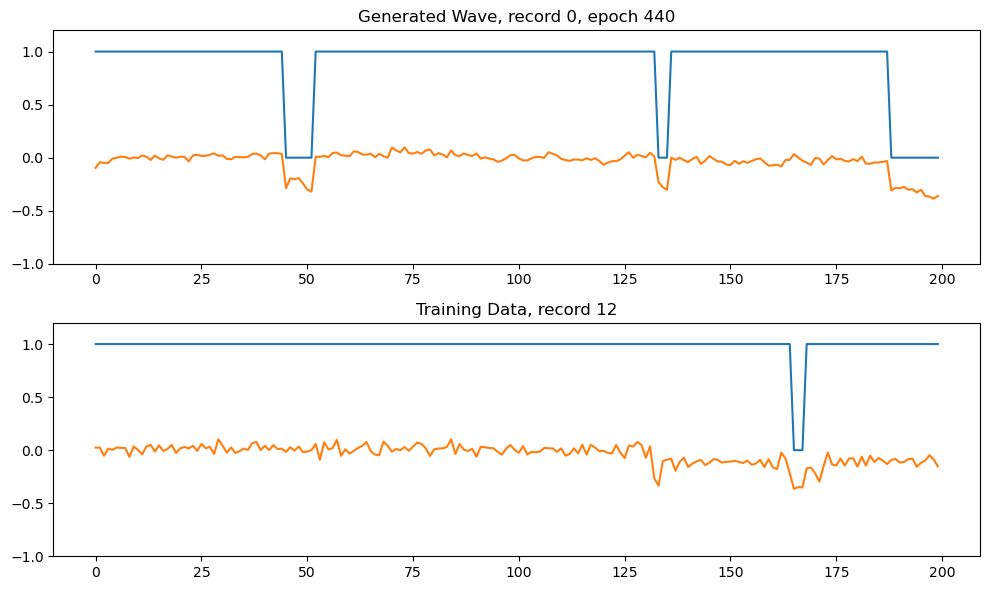

100%|██████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Data saved to markovData/output.parquet
Epoch 442/20000
dLR: 3.000e-06,                    gLR: 3.000e-05


 49%|███████████▏           | 18/37 [02:38<02:46,  8.79s/it]


KeyboardInterrupt: 

In [34]:
writeNow=False
epochs=20000
train(training_dataset, epochs)

In [36]:
writeMe()

100%|████████████████████████████████████████████████████| 10000/10000 [2:30:22<00:00,  1.11it/s]


Data saved to markovData/output.parquet
